In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble
import dill as pickle

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
opts = {'img_dir': 'data/tuberculosis-phonecamera/images/',
        'annotation_dir': 'data/tuberculosis-phonecamera/annotation/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (160,160),
        'image_downsample' : 8,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

In [3]:
reload(readdata)

<module 'readdata' from 'readdata.pyc'>

In [4]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y,train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y,test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=100)
#test_X, test_y = readdata.balance(test_X, test_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)

print '\n'
print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

[****************100%******************]  633 of 633 complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

View a random selection of positive and negative patches to see if they look right

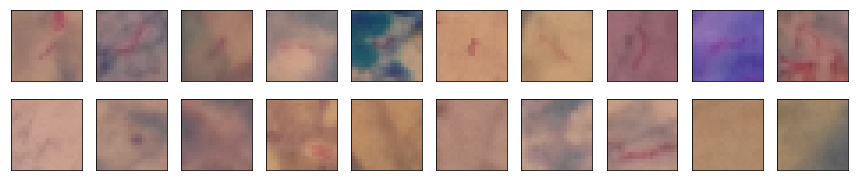

In [5]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

### CNN training

In [7]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('lstm', layers.LSTMLayer),#ain_y' is not
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    lstm_num_units=50,
       
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(500).fit(train_X, train_y)

# Neural Network with 27448 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   3x20x20
  1  conv1   7x18x18
  2  pool1   7x9x9
  3  lstm    7x50
  4  output  2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.68442     0.67497    1.01401      0.57540  20.63s
      2     0.67030     0.66473    1.00837      0.60016  20.90s
      3     0.65711     0.64453    1.01952      0.63437  20.51s
      4     0.63196     0.61643    1.02519      0.68428  20.01s
      5     0.59843     0.57719    1.03680      0.73563  20.09s
      6     0.55235     0.51968    1.06287      0.77854  22.13s
      7     0.48156     0.44075    1.09259      0.83307  21.25s
      8     0.40004     0.35472    1.12775      0.87673  21.33s
      9     0.32606     0.30122    1.08248      0.89862  20.56s
     10     0.28649     0.27170    1.05444      0.90575  21.44s
     11     0.26538     0.255

     97     0.16327     0.16130    1.01222      0.94365  20.19s
     98     0.16278     0.16089    1.01176      0.94377  20.21s
     99     0.16230     0.16036    1.01209      0.94390  20.17s
    100     0.16184     0.15982    1.01264      0.94446  20.18s
    101     0.16142     0.15939    1.01275      0.94446  20.18s
    102     0.16101     0.15898    1.01275      0.94452  20.22s
    103     0.16062     0.15854    1.01312      0.94452  20.22s
    104     0.16018     0.15808    1.01328      0.94465  20.22s
    105     0.15976     0.15765    1.01341      0.94496  20.19s
    106     0.15936     0.15719    1.01376      0.94527  20.18s
    107     0.15895     0.15676    1.01396      0.94546  20.17s
    108     0.15855     0.15633    1.01419      0.94565  20.29s
    109     0.15800     0.15585    1.01378      0.94590  20.74s
    110     0.15755     0.15545    1.01352      0.94659  20.12s
    111     0.15712     0.15497    1.01386      0.94646  20.10s
    112     0.15668     0.15458    1.013

    202     0.13234     0.13946    0.94894      0.95334  21.23s
    203     0.13213     0.13946    0.94746      0.95347  22.40s
    204     0.13200     0.13959    0.94567      0.95341  22.01s
    205     0.13193     0.13965    0.94471      0.95328  22.20s
    206     0.13179     0.13965    0.94372      0.95316  22.30s
    207     0.13167     0.13976    0.94209      0.95334  20.82s
    208     0.13153     0.13986    0.94048      0.95322  21.09s
    209     0.13139     0.14007    0.93799      0.95309  22.98s
    210     0.13124     0.14015    0.93645      0.95297  22.82s
    211     0.13115     0.14018    0.93561      0.95297  20.92s
    212     0.13103     0.14025    0.93432      0.95316  21.18s
    213     0.13099     0.14028    0.93376      0.95316  20.63s
    214     0.13084     0.14029    0.93262      0.95316  21.95s
    215     0.13072     0.14030    0.93178      0.95316  21.33s
    216     0.13063     0.14023    0.93155      0.95328  21.69s
    217     0.13050     0.14021    0.930

    311     0.12004     0.13762    0.87223      0.95328  20.50s
    312     0.11995     0.13762    0.87157      0.95341  20.53s
    313     0.11986     0.13762    0.87095      0.95347  20.56s
    314     0.11977     0.13760    0.87041      0.95347  20.54s
    315     0.11968     0.13758    0.86990      0.95341  20.47s
    316     0.11959     0.13755    0.86941      0.95347  21.40s
    317     0.11951     0.13755    0.86889      0.95347  20.42s
    318     0.11943     0.13752    0.86844      0.95347  20.41s
    319     0.11935     0.13750    0.86803      0.95347  20.45s
    320     0.11926     0.13753    0.86720      0.95341  20.38s
    321     0.11918     0.13751    0.86670      0.95341  20.47s
    322     0.11908     0.13750    0.86604      0.95347  20.38s
    323     0.11901     0.13744    0.86589      0.95353  20.33s
    324     0.11890     0.13741    0.86527      0.95359  20.32s
    325     0.11882     0.13739    0.86485      0.95353  20.31s
    326     0.11874     0.13738    0.864

    414     0.11139     0.13234    0.84169      0.95459  20.11s
    415     0.11131     0.13232    0.84128      0.95459  20.17s
    416     0.11124     0.13228    0.84094      0.95459  20.17s
    417     0.11116     0.13227    0.84041      0.95453  20.21s
    418     0.11108     0.13224    0.84001      0.95441  20.19s
    419     0.11101     0.13220    0.83969      0.95441  20.16s
    420     0.11094     0.13216    0.83943      0.95447  20.10s
    421     0.11087     0.13213    0.83911      0.95453  20.12s
    422     0.11080     0.13208    0.83883      0.95459  20.12s
    423     0.11073     0.13204    0.83861      0.95447  20.09s
    424     0.11065     0.13200    0.83828      0.95447  20.08s
    425     0.11058     0.13196    0.83798      0.95459  20.07s
    426     0.11051     0.13193    0.83764      0.95466  20.13s
    427     0.11044     0.13188    0.83742      0.95472  20.12s
    428     0.11036     0.13183    0.83717      0.95466  20.09s
    429     0.11029     0.13179    0.836

### Make predictions and evaluate on test data

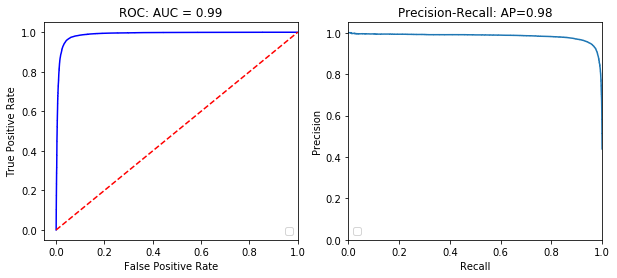

In [9]:
y_pred = cnn.predict_proba(test_X)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

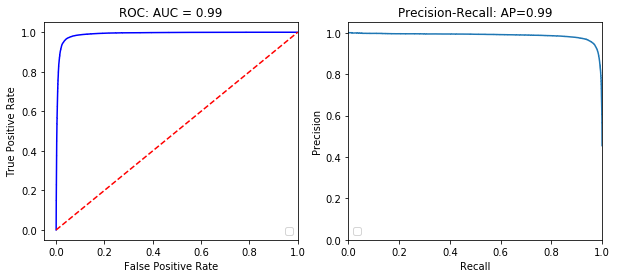

In [10]:
y_pred = cnn.predict_proba(train_X)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(train_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(train_y, y_pred[:,1])
average_precision = metrics.average_precision_score(train_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

In [11]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='True positive rate')
plt.plot(false_positive_rate, thresholds, label='False positive rate')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(loc='upper left')

ValueError: Found arrays with inconsistent numbers of samples: [78835 79939]

**Examine mistakes to understand network performance: false positives.** 

Find the negative-labelled patches with highest prediction score

In [ ]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]

N_samples_to_display = 12
offset = 55
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % neg_scores[i+offset])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/tuberculosis-falsedetections.png', bbox_inches='tight')

See highest-scored test patches

In [ ]:
prob_range = [.95,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 12
offset = 0
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (tmp_scores[pos_indices[i+offset]]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/tuberculosis-detectedpatches.png', bbox_inches='tight')

See lowest scored test patches

In [ ]:
pos_indices = y_pred[:,1].argsort()

N_samples_to_display = 12

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (y_pred[pos_indices[i],1]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/tuberculosis-testpatches-lowprob.png', bbox_inches='tight')

### Example of objects detected in an entire image

The white boxes represent annotations in the training data. Red boxes are detections by the convnet.

In [ ]:
reload(det)

fname = testfiles[0]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.99
found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 8)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 8)

plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)

#cv2.imwrite('detectionimages/detected-' + os.path.basename(imfile),im)

### Evaluation: compare with classification based on morphological feature extraction

In [ ]:
featureset = [3,7,11,12,15,17]
centiles = [0,25,50,75,100]

pb = ProgressBar(train_X.shape[0])
train_X_f = []
for i in range(train_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(train_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    train_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
train_X_f = np.vstack(train_X_f)

test_X_f = []
for i in range(test_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(test_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    test_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
test_X_f = np.vstack(test_X_f)

In [ ]:
clf = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(train_X_f, train_y)
y_pred_CLF = clf.predict_proba(test_X_f)

In [ ]:
false_positive_rate_CNN, true_positive_rate_CNN, thresholds_CNN = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc_CNN = metrics.auc(false_positive_rate_CNN, true_positive_rate_CNN)

precision_CNN, recall_CNN, thresholds_CNN = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision_CNN = metrics.average_precision_score(test_y, y_pred[:, 1])

false_positive_rate_CLF, true_positive_rate_CLF, thresholds_CLF = metrics.roc_curve(test_y, y_pred_CLF[:,1])
roc_auc_CLF = metrics.auc(false_positive_rate_CLF, true_positive_rate_CLF)

precision_CLF, recall_CLF, thresholds_CLF = metrics.precision_recall_curve(test_y, y_pred_CLF[:,1])
average_precision_CLF = metrics.average_precision_score(test_y, y_pred_CLF[:, 1])

subplot(211)
plt.title('ROC' )
plt.plot(false_positive_rate_CNN, true_positive_rate_CNN, 'b', label='CNN: AUC=%.2f' % (roc_auc_CNN))
plt.plot(false_positive_rate_CLF, true_positive_rate_CLF, 'k--', label='ERT: AUC=%.2f' % (roc_auc_CLF))
plt.legend(loc='lower right')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(212)
plt.plot(recall_CNN, precision_CNN, label='CNN: AP=%.2f' % (average_precision_CNN))
plt.plot(recall_CLF, precision_CLF,'k--', label='ERT: AP=%.2f' % (average_precision_CLF))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")

plt.gcf().set_size_inches(4,10)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

In [ ]:
results = {
"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"false_positive_rate_CLF": false_positive_rate_CLF,
"true_positive_rate_CLF": true_positive_rate_CLF,
"roc_auc_CNN": roc_auc_CNN,
"roc_auc_CLF": roc_auc_CLF,
"recall_CNN": recall_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"recall_CLF": recall_CLF,
"precision_CLF": precision_CLF,
"average_precision_CLF": average_precision_CLF,
"opts": opts
}
import pickle
pickle.dump(results,open('tuberculosis-results.pkl','w'))